# Surface Air Quality and Meteorological Observations in the MASP

Developed by Alejandro Delgado

e-mail: adelgado@iag.usp.br


Import Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.cm import get_cmap
import cartopy
from cartopy import crs # becareful with this package, doesn't work well
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import OCEAN
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords
import wrf

## Merge the files of air quality and meteorological parameters into a single CSV file

We have several air stations where air quality and meteorological parameters are monitored each hour by [CETESB](https://qualar.cetesb.sp.gov.br/qualar/home.do) in the São Paulo state. The parameters are follows:

* **Meteorological parameters**:

  - temperature at 2 m above ground in ºC (`tc`)
  - relative humidity at 2 m above ground in % (`rh`)
  - solar radiation in W/m$^2$ (`sr`)
  - wind speed at 10 m above ground in m/s (`ws`)
  - wind direction at 10 m above ground in º (`wd`)

* **Air quality parameters**:

  - surface ozone concentration in $\mu$g m$^{-3}$ (`o3`)
  - nitrogen monoxide concentration in $\mu$g m$^{-3}$ (`no`)
  - nitrogen dioxide concentration in $\mu$g m$^{-3}$  (`no2`)
  - carbon monoxide concentration in ppm (`co`)

I downloaded air quality and meteorological parameters from CETESB for all stations only for September (years 2016, 2017 and 2018). To do this, I used `donwloaded_CETESB.py` and `qualar_py.py` Python scripts. The repository of these scripts are in my [github](https://github.com/adelgadop/PythonObsData).

In [2]:
stations = pd.read_csv('cetesb_station_2017_codes_qualr.csv',
                      encoding = "ISO-8859-1")
stations[stations['name'] == 'Guarulhos']
stations

,name,lat,lon,code
0,Americana,-22.724253,-47.339549,290
1,Araçatuba,-21.186841,-50.439317,107
2,Araraquara,-21.782522,-48.185832,106
3,Bauru,-22.326608,-49.092759,108
4,Cambuci,-23.567708,-46.612273,90
...,...,...,...,...
63,S.Miguel Paulista,-23.498526,-46.444803,236
64,Sorocaba,-23.502427,-47.479030,67
65,Taboão da Serra,-23.609324,-46.758294,103
66,Tatuí,-23.360752,-47.870799,256


On the other hand, I downloaded hourly data from air quality and meteorological parameters of three years (2016-2018), only for 6 stations, shown as follow:

In [3]:
sites = stations.loc[[9,22,39,47,61,67],:]
sites

,name,lat,lon,code
9,Carapicuíba,-23.531395,-46.835780,263
22,Guarulhos-Pimentas,-23.440117,-46.409949,279
39,Parque D.Pedro II,-23.544846,-46.627676,72
47,Ribeirão Preto,-21.153942,-47.828481,288
61,S.José Campos-Jd.Satelite,-23.223645,-45.890800,277
67,Taubaté,-23.032351,-45.575805,280


To merge all of this data downloaded, named as `sites`, we need the file `cetesb_station_2017_codes_qualr.csv`. With this file, we can merge the data in one file named `data` by running `mergedData.py`. If the output file exists, named as `airData.csv`, so we can read directly. Otherwise, it will take few minutes to run `mergedData.py` and to merge the data to generate `airData.csv`:

In [4]:
fileName = 'airData.csv'
if os.path.exists(fileName) is False:
    %run mergedData.py
else:
    data = pd.read_csv(fileName)
    data = data[['date','station','tc','rh','sr','ws','wd','o3','no','no2','co']]   
data

,date,station,tc,rh,sr,ws,wd,o3,no,no2,co
0,2016-01-01 00:00:00,Carapicuíba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,Carapicuíba,21.7,89.0,0.0,2.2,14.0,22.0,NaN,NaN,0.5
2,2016-01-01 02:00:00,Carapicuíba,21.4,90.0,0.0,2.5,19.0,28.0,4.0,14.0,0.5
3,2016-01-01 03:00:00,Carapicuíba,21.5,89.0,0.0,2.3,22.0,29.0,3.0,13.0,0.4
4,2016-01-01 04:00:00,Carapicuíba,21.4,90.0,0.0,1.8,346.0,28.0,2.0,12.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...
157861,2018-12-31 20:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157862,2018-12-31 21:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157863,2018-12-31 22:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157864,2018-12-31 23:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Drawing a Map of Air Quality and Meteorological Stations Network of CETESB

The map locations of these stations is shown as follow:

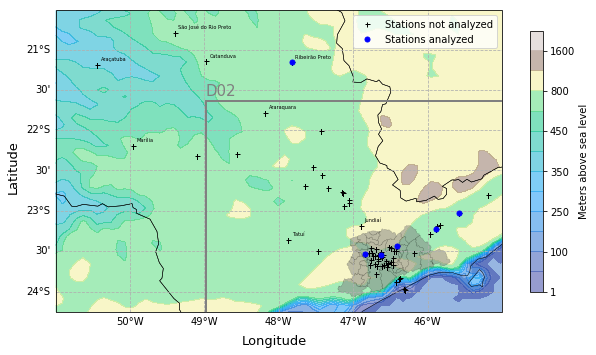

In [5]:
geo_d01 = Dataset('../3_Modeling/geo_em.d01.nc')
geo_d02 = Dataset('../3_Modeling/geo_em.d02.nc')
hgt_d01    = getvar(geo_d01, 'HGT_M')
hgt_d02    = getvar(geo_d02, 'HGT_M')
cart_proj  = get_cartopy(hgt_d01)
lats, lons = latlon_coords(hgt_d01)
lats_d02, lons_d02 = latlon_coords(hgt_d02)

## Chart
fig1 = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cart_proj)
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')

ax.add_feature(states, linewidth=.5,edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)
ax.set_extent([-51, -45, -24.25, -20.5])
#ax1.coastlines('50m', linewidth=0.8)

# ad MASP
fname = '../3_Modeling/MunRM07.shp'

shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                crs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature, linewidth=0.2, edgecolor = 'black', 
                facecolor = 'gray', alpha=0.5)

# d02 box
xlim_d02   = wrf.cartopy_xlim(hgt_d02)
ylim_d02   = wrf.cartopy_ylim(hgt_d02)
ax.add_patch(mpl.patches.Rectangle((xlim_d02[0], ylim_d02[0]), 
                                   xlim_d02[1]-xlim_d02[0], 
                                   ylim_d02[1]-ylim_d02[0],
             fill=None, lw=2, edgecolor='gray', zorder=10))
ax.text(xlim_d02[0]+(xlim_d02[1]-xlim_d02[0])*0.0, 
        ylim_d02[0]+(ylim_d02[1]-ylim_d02[0])*1.02, 
        'D02', size=15, color='gray', zorder=10)

# Set the contour levels
levels = [1, 50, 100, 200, 250, 300, 
          350, 400, 450, 500, 800, 1300, 
          1600, 2000]

plt.contourf(to_np(lons), to_np(lats), 
                to_np(hgt_d01), levels=levels,
                transform=crs.PlateCarree(),
                cmap=get_cmap("terrain"), alpha = 0.5)
plt.colorbar(ax=ax, label = 'Meters above sea level',shrink=0.8,
            pad = 0.05 )

# draw gridlines
gl = ax.gridlines(draw_labels=True, dms=True, alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.text(-51.65, -22.25, 'Latitude', transform=crs.Geodetic(),
         fontsize=13, rotation='vertical')
ax.text(-48.5, -24.65, 'Longitude', transform=crs.Geodetic(),
        fontsize=13, rotation='horizontal')

lon = stations.lon.values
lat = stations.lat.values
num = [1,2,10,30,33,47,59,66] # index of stations
for i in num:
    ax.text(lon[i]+0.05, lat[i]+0.05, stations.name.values[i], transform=crs.Geodetic(),
            fontsize=5, rotation='horizontal')
ax.plot(lon, lat,'+',markersize=5, color = 'k', label='Stations not analyzed',
        transform=crs.Geodetic())
ax.plot(sites.lon.values, sites.lat.values,'o', label='Stations analyzed',
        markersize=5, color = 'b', transform=crs.Geodetic());
ax.legend()
fig1.savefig("../4_Draft_Report/Dissertation/fig/map_stations.pdf",bbox_inches='tight');

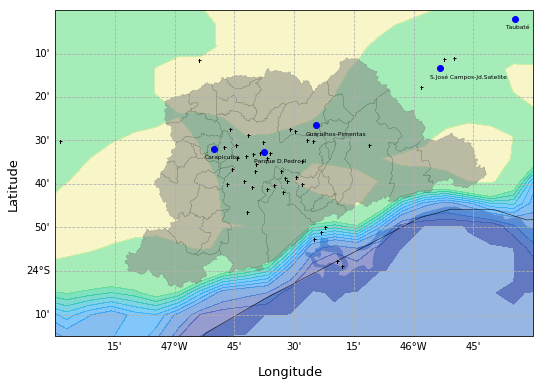

In [6]:
## Chart
fig2 = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cart_proj)
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')

ax.add_feature(states, linewidth=.5,edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)
ax.set_extent([-47.5, -45.5, -24.25, -23.0])
#ax1.coastlines('50m', linewidth=0.8)

# ad MASP
fname = '../3_Modeling/MunRM07.shp'

shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                crs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature, linewidth=0.2, edgecolor = 'black', 
                facecolor = 'gray', alpha=0.5)

# Set the contour levels
levels = [1, 50, 100, 200, 250, 300, 
          350, 400, 450, 500, 800, 1300, 
          1600, 2000]

plt.contourf(to_np(lons), to_np(lats), 
                to_np(hgt_d01), levels=levels,
                transform=crs.PlateCarree(),
                cmap=get_cmap("terrain"), alpha = 0.5)

# draw gridlines
gl = ax.gridlines(draw_labels=True, dms=True, alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.text(-47.7, -23.6, 'Latitude', transform=crs.Geodetic(),
         fontsize=13, rotation='vertical')
ax.text(-46.65, -24.40, 'Longitude', transform=crs.Geodetic(),
        fontsize=13, rotation='horizontal')

lon = stations.lon.values
lat = stations.lat.values
num = [0,1,2,4,5] # index of stations
for i in num:
    ax.text(sites.lon.values[i]-0.04, sites.lat.values[i]-0.04, 
            sites.name.values[i], transform=crs.Geodetic(),
            fontsize=6, rotation='horizontal')
ax.plot(lon, lat,'+',markersize=3, color = 'k', transform=crs.Geodetic())
ax.plot(sites.lon.values, sites.lat.values,'o',
        markersize=6, color = 'b', transform=crs.Geodetic())
fig2.savefig("../4_Draft_Report/Dissertation/fig/masp_stations.pdf",bbox_inches='tight');

## Charts

We can define the style of the chart by selecting an available:

In [7]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [8]:
#plt.style.use('ggplot')
plt.style.use('seaborn')
#sns.set_style("ticks")

### Datetime format

We define the column `date` as index:

In [9]:
data.loc[:,'date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data.set_index('date', inplace=True)
data.head()

,station,tc,rh,sr,ws,wd,o3,no,no2,co
date,,,,,,,,,,
2016-01-01 00:00:00,Carapicuíba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,Carapicuíba,21.7,89.0,0.0,2.2,14.0,22.0,NaN,NaN,0.5
2016-01-01 02:00:00,Carapicuíba,21.4,90.0,0.0,2.5,19.0,28.0,4.0,14.0,0.5
2016-01-01 03:00:00,Carapicuíba,21.5,89.0,0.0,2.3,22.0,29.0,3.0,13.0,0.4
2016-01-01 04:00:00,Carapicuíba,21.4,90.0,0.0,1.8,346.0,28.0,2.0,12.0,0.4


First, we add two columns `month` and `hour`.

In [10]:
data['month'] = data.index.strftime('%b')
data['hour'] = data.index.hour
data

,station,tc,rh,sr,ws,wd,o3,no,no2,co,month,hour
date,,,,,,,,,,,,
2016-01-01 00:00:00,Carapicuíba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,0
2016-01-01 01:00:00,Carapicuíba,21.7,89.0,0.0,2.2,14.0,22.0,NaN,NaN,0.5,Jan,1
2016-01-01 02:00:00,Carapicuíba,21.4,90.0,0.0,2.5,19.0,28.0,4.0,14.0,0.5,Jan,2
2016-01-01 03:00:00,Carapicuíba,21.5,89.0,0.0,2.3,22.0,29.0,3.0,13.0,0.4,Jan,3
2016-01-01 04:00:00,Carapicuíba,21.4,90.0,0.0,1.8,346.0,28.0,2.0,12.0,0.4,Jan,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,20
2018-12-31 21:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,21
2018-12-31 22:00:00,Parque D.Pedro II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,22


### Meteorological parameters

In [11]:
met_keys = list(data.columns[1:5])
met_values = ['2-m Temperature (ºC)'        , 'Relative Humidity (%)',
              'Solar Radiation (W m$^{-2}$)', '10-m Wind Speed (m s$^{-1}$)']

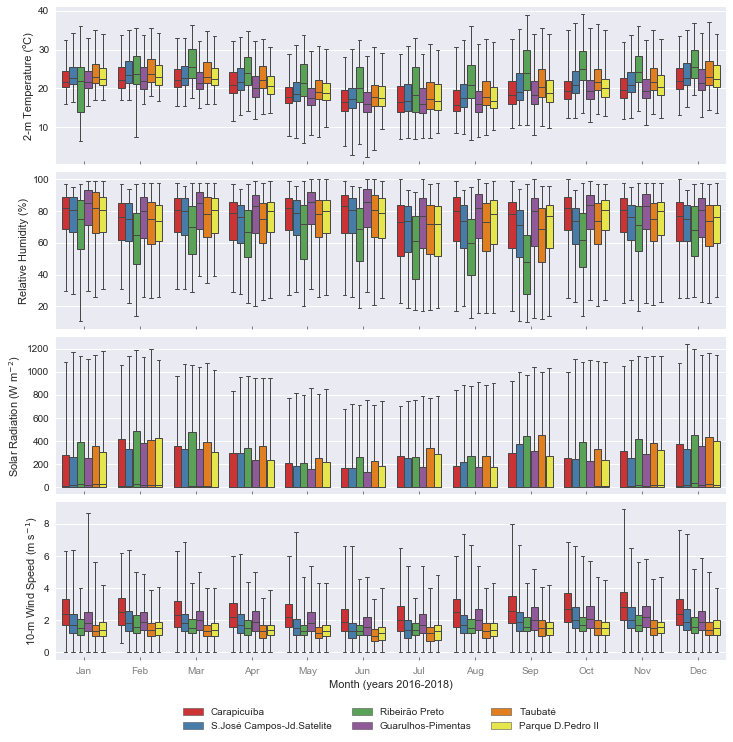

In [12]:
fig, ax = plt.subplots(4, figsize=(12,12), sharex=True,gridspec_kw={'hspace': 0.05})

for i in range(0,4):
    sns.boxplot(x='month',y=met_keys[i],data=data, hue='station',linewidth=1,
                palette="Set1", ax=ax[i],whis=6)
    ax[i].set_ylabel(met_values[i])
    ax[i].set_xlabel('')
    ax[i].tick_params(axis="x", direction="in",length=3, width=1, colors='gray')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol = 3)
plt.xlabel('Month (years 2016-2018)')
    
for i in range(0,3):
    ax[i].get_legend().remove()
    
fig.savefig("../4_Draft_Report/Dissertation/fig/Met_boxplot.pdf",bbox_inches='tight');  


#### Draw a Wind Rose Plots

In [13]:
from windrose import plot_windrose
import matplotlib.cm as cm

In [14]:
df = data[['ws','wd','station','month']].dropna()
df
sitesNames = data.station.unique()
sitesNames

array(['Carapicuíba', 'S.José Campos-Jd.Satelite', 'Ribeirão Preto',
       'Guarulhos-Pimentas', 'Taubaté', 'Parque D.Pedro II'], dtype=object)

For choose colors for `windrose`, see [Colormaps in Matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html):

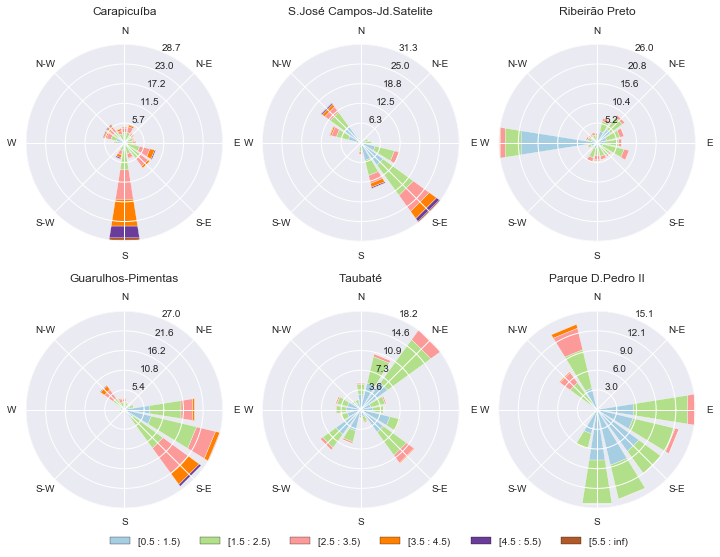

In [15]:
    nrows, ncols = 2, 3
    fig = plt.figure(figsize=(12,9))
    bins = np.arange(0.5, 6, 1)

    #fig.suptitle("Wind speed - %d")
    for i in range(1, 7):
        ax = fig.add_subplot(nrows, ncols, i, projection='windrose')
        title = sitesNames[i-1]
        ax.set_title(title, pad = 20)
        try:
            wind = df[df.station == sitesNames[i-1]]
        except KeyError:
            continue
        direction = wind['wd'].values
        var = wind['ws'].values
        ax.bar(direction, var, bins=bins, normed = True, cmap=cm.Paired, edgecolor='white')
plt.legend(loc='best', bbox_to_anchor=(0.7, -0.1), ncol = 6)
fig.savefig("../4_Draft_Report/Dissertation/fig/WR_plot.pdf",bbox_inches='tight');

### Air Quality Parameters

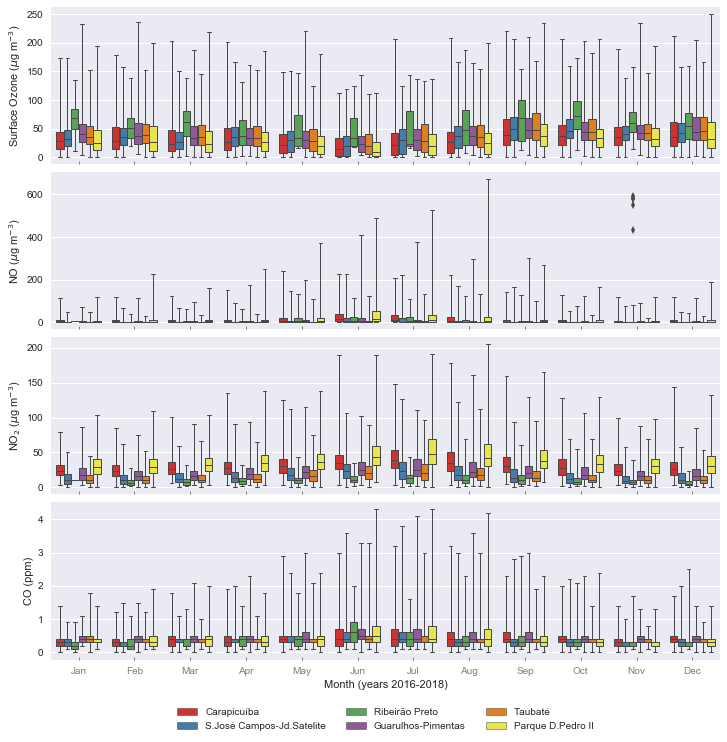

In [16]:
aq_keys = list(data.columns[6:10])
aq_values = ['Surface Ozone ($\mu$g m$^{-3}$)', 'NO ($\mu$g m$^{-3}$)', 
             'NO$_2$ ($\mu$g m$^{-3}$)'       , 'CO (ppm)' ]

fig, ax = plt.subplots(4, figsize=(12,12),sharex=True,gridspec_kw={'hspace': 0.05})

for i in range(0,4):
    sns.boxplot(x='month',y=aq_keys[i],data=data, hue='station',
                linewidth=1,palette="Set1", ax=ax[i],whis=100)
    ax[i].set_ylabel(aq_values[i])
    ax[i].set_xlabel('')
    ax[i].tick_params(axis="x", direction="in",length=3, width=1, colors='gray')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol = 3)
plt.xlabel('Month (years 2016-2018)')
    
for i in range(0,3):
    ax[i].get_legend().remove()
    
fig.savefig("../4_Draft_Report/Dissertation/fig/AQ_boxplot.pdf",bbox_inches='tight'); 

#### Average by hour and month

Relation between surface ozone hourly concentrations, temperature and solar radiation 

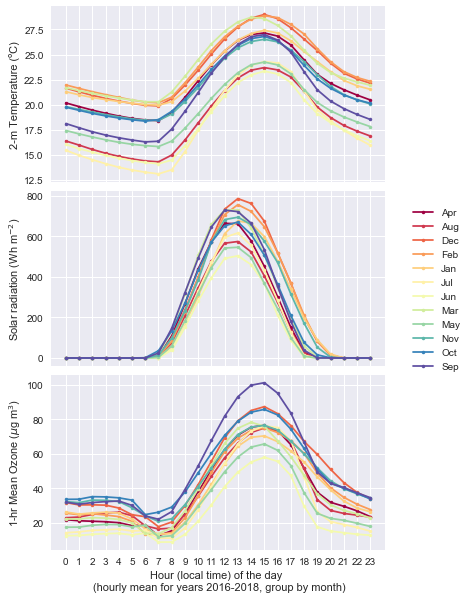

In [17]:
fig, ax = plt.subplots(3,figsize=(6,10),sharex=True,gridspec_kw={'hspace': 0.05})

color = 'Spectral' # 'Set1' 'Dark2' 'tab20'

# Temperature
ax[0].set_xticks(data['hour'].unique())
# Average by hour and month for all years and stations
tcHour = data.groupby(["hour", "month"]).mean()['tc'].unstack()
tcHour.plot(ax=ax[0], marker = '.',colormap=color)
ax[0].set_ylabel('2-m Temperature (ºC)')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 6)

# Solar Radiation
ax[1].set_xticks(data['hour'].unique())
# Average by hour and month for all years and stations
srHour = data.groupby(["hour", "month"]).mean()['sr'].unstack()
srHour.plot(ax=ax[1],marker='.',colormap=color)
ax[1].set_ylabel('Solar radiation (Wh m$^{-2}$)')

# Surface Ozone
ax[2].set_xticks(data['hour'].unique())
# Average by hour and month for all years and stations
o3Hour = data.groupby(["hour", "month"]).mean()['o3'].unstack()
o3Hour.plot(marker=".", ax=ax[2],colormap=color)
ax[2].set_xlabel('Hour (local time) of the day \n (hourly mean for years 2016-2018, group by month)')
ax[2].set_ylabel('1-hr Mean Ozone ($\mu$g m$^{3}$)')

for i in range(0,3):
    ax[i].get_legend().remove()
    ax[i].tick_params(axis="x", direction="in")
    ax[i].grid(color='white', linestyle='-', linewidth=1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 2), ncol = 1);
fig.savefig("../4_Draft_Report/Dissertation/fig/o3HourlyMean.pdf",bbox_inches='tight');

Then, we group the average data by `hour`, `month`, and `station`:

In [18]:
by_month= data.groupby(['month','hour','station']).mean()[['no','no2']].reset_index()
by_month

,month,hour,station,no,no2
0,Apr,0,Carapicuíba,10.597561,35.268293
1,Apr,0,Guarulhos-Pimentas,10.971014,26.173913
2,Apr,0,Parque D.Pedro II,11.288889,41.088889
3,Apr,0,Ribeirão Preto,13.920000,13.420000
4,Apr,0,S.José Campos-Jd.Satelite,2.666667,19.988889
...,...,...,...,...,...
1723,Sep,23,Guarulhos-Pimentas,9.407895,33.157895
1724,Sep,23,Parque D.Pedro II,16.650000,49.212500
1725,Sep,23,Ribeirão Preto,13.600000,20.583333
1726,Sep,23,S.José Campos-Jd.Satelite,4.333333,21.384615


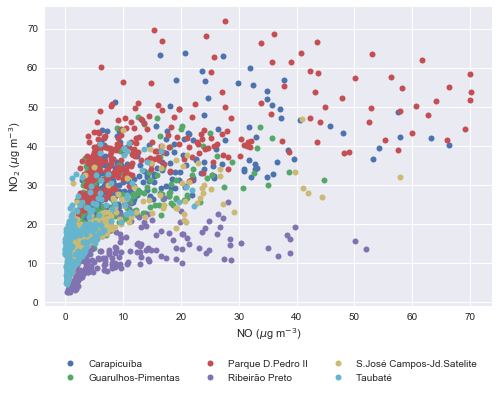

In [19]:
#plt.style.use('ggplot')
#sns.set_style("ticks")
groups = by_month.groupby('station')
# Plot
fig, ax = plt.subplots()
color = cm.Set1 # see how put this on the figure 
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups: # name is ok for groupby, to verify print(name) and print(group) to understand
    ax.plot(group.no, group.no2, marker='.',  # be careful with the marker = '+' doesn't work for all plt.style
            linestyle='', ms=12, label=name)
    ax.set_xlabel('NO ($\mu$g m$^{-3}$)')
    ax.set_ylabel('NO$_2$ ($\mu$g m$^{-3}$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 3)
fig.savefig("../4_Draft_Report/Dissertation/fig/NoNo2_ratio.pdf",bbox_inches='tight');

### Hourly Ozone, CO, NO, NO$_2$ behaviour in September, 2018

In [20]:
aqData = data[['month','hour','station','co','no','no2','o3']]
aqData = aqData[aqData['month'] == 'Sep']
aqData

,month,hour,station,co,no,no2,o3
date,,,,,,,
2016-09-01 00:00:00,Sep,0,Carapicuíba,0.5,20.0,41.0,7.0
2016-09-01 01:00:00,Sep,1,Carapicuíba,0.3,NaN,NaN,15.0
2016-09-01 02:00:00,Sep,2,Carapicuíba,0.3,2.0,26.0,19.0
2016-09-01 03:00:00,Sep,3,Carapicuíba,0.3,4.0,24.0,14.0
2016-09-01 04:00:00,Sep,4,Carapicuíba,0.3,3.0,13.0,16.0
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,Sep,19,Parque D.Pedro II,0.5,1.0,49.0,38.0
2018-09-30 20:00:00,Sep,20,Parque D.Pedro II,0.6,3.0,62.0,22.0
2018-09-30 21:00:00,Sep,21,Parque D.Pedro II,0.5,2.0,51.0,31.0


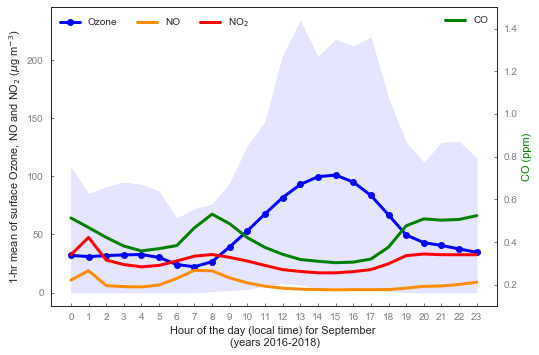

In [21]:
# Style of the Canvas
plt.style.use('seaborn-whitegrid')
sns.set_style("ticks")

# Data
Mean = aqData.groupby(['hour']).mean()[['co','no','no2','o3']]
Max = aqData.groupby(['hour']).max()[['co','no','no2','o3']]
Min = aqData.groupby(['hour']).min()[['co','no','no2','o3']]

# Design
fig= plt.figure()

ax1 = fig.gca()
plt.xticks(np.arange(0,24,1))
ax1.grid(False)
alpha = 0.1
ax1.fill_between(Mean.index, Max.o3, Min.o3, color='b', alpha=alpha)
ax1.plot(Mean.index,Mean.o3, color='b', label='Ozone',lw=3, marker = 'o')
#ax1.fill_between(Mean.index, Max.no, Min.no, color='darkorange', alpha=alpha)
ax1.plot(Mean.index,Mean.no, color='darkorange', label='NO',lw=3)
#ax1.fill_between(Mean.index, Max.no2, Min.no2, color='r', alpha=alpha)
ax1.plot(Mean.index,Mean.no2, color='r', label='NO$_2$', lw=3)
ax1.set_ylabel('1-hr mean of surface Ozone, NO and NO$_2$ ($\mu$g m$^{-3}$)')
ax1.legend(loc='upper left', ncol = 3) #bbox_to_anchor=(0.5, -0.15)
ax1.tick_params(axis="x", direction="in",length=3, width=1, colors='gray')
ax1.tick_params(axis="y", direction="in",length=3, width=1, colors='gray')

ax2 = ax1.twinx()
ax2.tick_params(axis="y", direction="in",length=3, width=1, colors='gray')
#ax2.fill_between(Mean.index, Max.co, Min.co, color='g', alpha=alpha)
ax2.plot(Mean.index,Mean.co, color='g', label='CO',lw=3)
ax2.set_ylabel('CO (ppm)')
ax2.set_ylim(0.1, 1.5)

ax2.yaxis.label.set_color('g')
ax2.legend(loc='upper right', ncol = 3) #bbox_to_anchor=(0.5, -0.20)
ax1.set_xlabel('Hour of the day (local time) for September \n (years 2016-2018)')
fig.savefig("../4_Draft_Report/Dissertation/fig/aqHourSep.pdf",bbox_inches='tight');